In [1]:
import numpy as np
import pandas as pd
from tslearn.neighbors import KNeighborsTimeSeries
import os
import matplotlib.pyplot as plt
import keras
from Counterfactuals.utils.counterfactual_utils import ucr_data_loader, convert_string_to_array
from Counterfactuals.Optimization.problem import CounterfactualProblem

#Optimization
#Algorithm
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3

from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.termination import get_termination

In [7]:
class CounterfactualGenerator():
    def __init__(self, model, X_train, X_test, y_test, y_train, weights):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_test = y_test
        self.y_train = y_train
        self.y_pred = np.argmax(self.model.predict(self.X_test), axis=1)
        self.y_pred_train = np.argmax(self.model.predict(self.X_train), axis=1)
        self.weights = weights
        self.nuns = []

    def findSubarray(self, a: list, k: int): #used to find the maximum contigious subarray of length k in the explanation weight vector
        
        n = len(a)
            
        vec = [] 

        # Iterate to find all the sub-arrays 
        for i in range(n-k+1): 
            temp=[] 

            # Store the sub-array elements in the array 
            for j in range(i,i+k): 
                temp.append(a[j]) 

            # Push the vector in the container 
            vec.append(temp) 

        sum_arr = []
        for v in vec:
            sum_arr.append(np.sum(v))

        return (vec[np.argmax(sum_arr)])
    
    def nearest_unlike_neighbour(self, query, predicted_label, distance, n_neighbors):
        """
        Find the Nearest Unlike Neighbour (nun) for each instance in the Test Dataset

        Args:
            query: the instance for which we want to find its nun
            predicted_label = the classifier's predicted label for the query
            distance = distance metric to be used for the KNeighborsTimeSeries 
            n_neighbors = number of neighbors to be retrieved
        """
        df = pd.DataFrame(self.y_train, columns = ['label'])
        df.index.name = 'index'

        knn = KNeighborsTimeSeries(n_neighbors=n_neighbors, metric = distance)

        #Fit the KNN Algorithm with those instances that ARE NOT labelled as the Predicted Label    
        knn.fit(self.X_train[list(df[df['label'] != predicted_label].index.values)])
    
        dist, ind = knn.kneighbors(query.reshape(1,query.shape[0], query.shape[1]), return_distance=True)
        return dist[0], df[df['label'] != predicted_label].index[ind[0][:]]
    
    def naive_approach(self, instance, nun, subarray_length=1):
        """
        Swap the original instance's values for those of the nearest unlike neighbour (nun). Naive Approach. 

        Args:
            instance: the index of the original instance in the Test dataset
            nun: the index of the nearest unlike neighbour in the Train dataset
            subarray_length = The length of the sub-sequence that will be modified 
        """
        #Initalize values
        most_influencial_array = self.findSubarray(self.weights[nun], subarray_length)

        starting_point = np.where(self.weights[nun]==most_influencial_array[0])[0][0]

        counterfactual = np.concatenate((self.X_test[instance][:starting_point], (self.X_train[nun][starting_point:subarray_length+starting_point]), 
                                        self.X_test[instance][subarray_length+starting_point:]))
        
        prob_target = self.model.predict(counterfactual.reshape(1,counterfactual.shape[0], counterfactual.shape[1]))[0][self.y_pred_train[nun]]

        
        
        while prob_target <= 0.5:
            subarray_length +=1
    
            #Get the sub-sequence.    
            most_influencial_array = self.findSubarray((self.weights[nun]), subarray_length)
            #Timestep where it starts
            starting_point = np.where(self.weights[nun]==most_influencial_array[0])[0][0]
            
            #Create the counterfactual by swapping the original instance's values for the NUN's.
            counterfactual = np.concatenate((self.X_test[instance][:starting_point], 
                                             (self.X_train[nun][starting_point:subarray_length+starting_point]), 
                                            self.X_test[instance][subarray_length+starting_point:]))
            
            #Feed new instance to model and check if the probability target changed. 
            prob_target = self.model.predict(counterfactual.reshape(1,counterfactual.shape[0], counterfactual.shape[1]))[0][self.y_pred_train[nun]]
        
        sparsity = np.mean(self.X_test[instance].flatten() == counterfactual.flatten())
        counterfactual_dict = {'Solution': [counterfactual], 'Window': subarray_length, 'Sparsity': sparsity, 'Precision': prob_target, 'Test Instance':instance, 'NUN Instance':nun}
        counterfactual_df = pd.DataFrame(counterfactual_dict)
        return counterfactual_df
    
    def optimization(self, instance_index:int, nun_index:int):
        #Initialize Values
        query = self.X_test[instance_index]
        #starting_point = self.counterfactuals[instance_index][1]
        subsequence_length = self.counterfactuals[instance_index][2]
        #end_point = starting_point + subsequence_length
        nun = self.X_train[nun_index]
        solutions = pd.DataFrame(columns=["Solution", "Window", "Sparsity", "Precision", "Test Instance", "NUN Instance"])
        no_solution = 0

        #Start Optimization Search
        for window in range(subsequence_length, 1, -1): 
            most_influencial_array = self.findSubarray((self.weights[nun_index]), window)
            #Timestep where it starts
            starting_point = np.where(self.weights[nun_index]==most_influencial_array[0])[0][0]
            end_point = starting_point + window

            #Define the Counterfactual Problem
            problem = CounterfactualProblem(query, nun, nun_index, starting_point, window, self.model, self.y_pred_train)
        
            # create the reference directions to be used for the optimization
            ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=12)
            
            #NGSA-III Algorithm
            """
            algorithm = NSGA3(pop_size=100,
                    ref_dirs = ref_dirs,
                    sampling=BinaryRandomSampling(),
                    crossover=TwoPointCrossover(),
                    mutation=BitflipMutation(),
                    )
            """
            algorithm = NSGA2(pop_size=100,
                    sampling=BinaryRandomSampling(),
                    crossover=TwoPointCrossover(),
                    mutation=BitflipMutation(),
                    )
        
            #Only do 300 generations
            termination = get_termination("n_gen", 300)
        
            #Run Optimization
            res = minimize(problem,algorithm,termination,seed=1,verbose=False)

            #Check if the optimization actually gave a solution
            if res.X is None:
                no_solution = no_solution + 1
            else:
                for x in res.X:
                    x_reshaped = res.X[0].reshape(window, query.shape[1])
                    op_counterfactual = np.copy(query)
                    op_counterfactual[starting_point:end_point][x_reshaped] = nun[starting_point:end_point][x_reshaped]  

                    op_counterfactual_reshaped = op_counterfactual.reshape(1,op_counterfactual.shape[0], op_counterfactual.shape[1])
                    f1 = self.model.predict(op_counterfactual_reshaped)[0][self.y_pred_train[nun_index]]
                    f2 = np.mean(query.flatten() == op_counterfactual.flatten())
                    row_dict = {'Solution': [op_counterfactual], 'Window': window, 'Sparsity': f2, 'Precision': f1, 'Test Instance':instance_index, 'NUN Instance': nun_index}
                    row_df = pd.DataFrame(row_dict)
                    solutions = pd.concat([solutions, row_df], ignore_index=True)
            
            if no_solution == 3:
                break
            
        return solutions

    def counterfactual_generator(self, directory = os.getcwd(), save_counterfactuals = False, optimization=False):
        
        #Generate Next Unilikely Neighbour
        for instance in range(len(self.X_test)):
            self.nuns.append(self.nearest_unlike_neighbour(self.X_test[instance], self.y_pred[instance], 'euclidean', 1)[1][0])
        self.nuns = np.array(self.nuns)

        test_instances = np.array(range(len(self.X_test)))
        
        #Generate the Counterfactuals with the Naive Approach
        self.naive_counterfactuals = pd.DataFrame(columns=["Solution", "Window", "Sparsity", "Precision", "Test Instance", "NUN Instance"])
        for test_instance, nun in zip(test_instances, self.nuns):
            naives = self.naive_approach(test_instance,nun)
            self.naive_counterfactuals = pd.concat([self.naive_counterfactuals, naives], ignore_index=True)
        
        if optimization == True:
            #Optimize Counterfactuals
            self.optimized_counterfactuals = pd.DataFrame(columns=["Solution", "Window", "Sparsity", "Precision", "Test Instance", "NUN Instance"])
            for test_instance,nun in zip(test_instances, self.nuns):
                optimization = self.optimization(test_instance,nun)
                self.optimized_counterfactuals = pd.concat([self.optimized_counterfactuals, optimization], ignore_index=True)

            self.optimized_counterfactuals = self.optimized_counterfactuals.groupby('Test Instance', as_index=False).apply(lambda x: x.drop_duplicates(subset='Window')).reset_index(drop=True)

        if save_counterfactuals == True:
            np.save(str(directory+'_naive_counterfactuals.npy'), np.array(self.naive_counterfactuals))
            if optimization == True:
                self.optimized_counterfactuals.to_csv(str(directory+'_optimized_counterfactuals.csv'), index=False)
  
    def get_naive_counterfactual(self, instance:int):
        if hasattr(self, 'naive_counterfactuals'):
            return self.naive_counterfactuals[self.naive_counterfactuals["Test Instance"]==instance].iloc[0][0]
        else:
            raise AttributeError("Counterfactuals attribute does not exist yet. Please first run the function 'counterfactual_generator")          

    def get_optimized_counterfactual(self, instance:int, precision:bool):
        if hasattr(self, 'optimized_counterfactuals'):
            #Get the counterfactuals for instance x
            ce_instance = self.optimized_counterfactuals[self.optimized_counterfactuals["Test Instance"]==instance]
            if precision == True:
                #Return the counterfactual with highest precision
                return ce_instance.sort_values("Precision", ascending=False).iloc[0][0]
            else:
                #Return the counterfactual with highest sparsity
                return ce_instance.sort_values("Sparsity", ascending=False).iloc[0][0]
        else:
            raise AttributeError("Optimized Counterfactuals have not been generated yet. Run 'counterfactual_generator' with arg 'optimization' as True")

    def visualize_counterfactuals(self, instance:int, optimized=False, precision=True):
        sample = self.X_test[instance]
        if optimized == False:
            counterfactual = self.get_naive_counterfactual(instance)
        else:
            counterfactual = self.get_optimized_counterfactual(instance, precision)

            
        # Reshape Time Series for consistency with usual time series format [time, dimension]
        sample_reshaped = sample.T
        counterfactual_reshaped = counterfactual.T

        # Determine the number of dimensions (subplots) based on the input series
        num_dimensions = sample_reshaped.shape[0]

        # Set the style
        plt.style.use('seaborn-darkgrid') 
            
        # Create a plot with a dynamic number of subplots for the time series
        fig, axes = plt.subplots(num_dimensions, 1, figsize=(15, 3 * num_dimensions))

        # Iterate through each dimension
        for i, ax in enumerate(axes if num_dimensions > 1 else [axes]):
            # Plot the original series
            original_line, = ax.plot(sample_reshaped[i], label='Original', color='skyblue', linewidth=2)

            # Find the indices where the original and counterfactual differ
            diffs = np.where(sample_reshaped[i] != counterfactual_reshaped[i])[0]

            if diffs.size > 0:  # If there are differences
                # Determine the start and end of the continuous differing sequence
                start_diff = diffs[0]
                end_diff = diffs[-1]

                # Plot the entire sub-sequence where differences occur in salmon color
                counterfactual_line, = ax.plot(range(start_diff, end_diff + 1), 
                                            counterfactual_reshaped[i, start_diff:end_diff + 1], 
                                            label='Counterfactual', color='salmon', linewidth=2, linestyle='--')
                
                # Connecting line: from the last unchanged point to the first changed point
                start_diff = diffs[0]  # Start of the differing subsequence
                if start_diff > 0:  # Make sure there's a point to connect from
                    ax.plot([start_diff - 1, start_diff], [sample_reshaped[i, start_diff - 1], counterfactual_reshaped[i, start_diff]], color='salmon', linewidth=2)
                    
                # Connecting line: from the last changed point to the next original point
                end_diff = diffs[-1]  # End of the differing subsequence
                if end_diff < sample_reshaped[i].size - 1:  # Make sure there's a point to connect to
                    ax.plot([end_diff, end_diff + 1], [counterfactual_reshaped[i, end_diff], sample_reshaped[i, end_diff + 1]], color='salmon', linewidth=2)

            
            # Set legend manually to ensure no duplicate labels
            if diffs.size > 0:
                ax.legend(handles=[original_line, counterfactual_line], fontsize=12)
            else:
                ax.legend(handles=[original_line], fontsize=12)

            ax.set_title(f"Dimension {i+1}", fontsize=14)
            ax.set_xlabel("Time", fontsize=12)
            ax.set_ylabel("Value", fontsize=12)
            ax.tick_params(axis='both', which='major', labelsize=10)
            ax.grid(True)  # Add gridlines

        plt.tight_layout()
        plt.show()

    def visualize_marks(self, instance:int, optimized=False, precision=True):
        sample = self.X_test[instance]
        if optimized == False:
            counterfactual = self.get_naive_counterfactual(instance)
        else:
            counterfactual = self.get_optimized_counterfactual(instance, precision)
            
        # Reshape Time Series for consistency with usual time series format [time, dimension]
        sample_reshaped = sample.T
        counterfactual_reshaped = counterfactual.T

        # Determine the number of dimensions (subplots) based on the input series
        num_dimensions = sample_reshaped.shape[0]

        # Set the style
        plt.style.use('seaborn-darkgrid')  # This applies a nice grid and background color
            
        # Create a plot with a dynamic number of subplots for the time series
        fig, axes = plt.subplots(num_dimensions, 1, figsize=(15, 3 * num_dimensions), sharex=True)

        # Iterate through each dimension
        for i, ax in enumerate(axes if num_dimensions > 1 else [axes]):
            # Plot where the original and counterfactual are the same
            same_indices = np.where(sample_reshaped[i] == counterfactual_reshaped[i])[0]
            diff_indices = np.where(sample_reshaped[i] != counterfactual_reshaped[i])[0]

            # Plot with dots
            if same_indices.size > 0:
                ax.plot(same_indices, sample_reshaped[i][same_indices], 'o', label='Same Values (OG)', color='blue', markersize=5)

            if diff_indices.size > 0:
                ax.plot(diff_indices, counterfactual_reshaped[i][diff_indices], 'o', label='Different Values (CE)', color='salmon', markersize=5)
                ax.plot(diff_indices, sample_reshaped[i][diff_indices], 'x', label='Different Values (OG)', color='green', markersize=5)
            # Set labels and legends
            ax.set_title(f"Dimension {i+1}", fontsize=14)
            ax.set_xlabel("Time", fontsize=12)
            ax.set_ylabel("Value", fontsize=12)
            ax.tick_params(axis='both', which='major', labelsize=10)
            ax.legend(fontsize=12)
            ax.grid(True)  # Add gridlines

        plt.tight_layout()
        plt.show()

    def load_optimized_solutions(self, directory:str):
        self.optimized_counterfactuals = pd.read_csv(directory)
        self.optimized_counterfactuals["Solution"] = self.optimized_counterfactuals["Solution"].apply(
        lambda x: convert_string_to_array(x, timesteps=self.X_train.shape[1], channels=self.X_train.shape[2])
)
        

# Run Code

In [8]:
dataset='BasicMotions'
X_train, y_train, X_test, y_test = ucr_data_loader(dataset)
model = keras.models.load_model('/Users/alanparedescetina/Tesis/Models/'+dataset+'_best_model.hdf5')
training_weights = np.load('/Users/alanparedescetina/Tesis/Counterfactuals/CAM/Weights/BasicMotions_training_weights.npy')

ce = CounterfactualGenerator(model, X_train, X_test, y_test, y_train, training_weights)
directory = str("/Users/alanparedescetina/Tesis/Counterfactuals/Native_Guides/Guides/"+dataset+'_counterfactuals.npy')
ce.counterfactual_generator(directory, save_counterfactuals=False, optimization=False)
ce.load_optimized_solutions("/Users/alanparedescetina/Tesis/Solutions/solutions_NSGA3.csv")
ce.optimized_counterfactuals = ce.optimized_counterfactuals.groupby('Test Instance', as_index=False).apply(lambda x: x.drop_duplicates(subset='Window')).reset_index(drop=True)

2024-05-06 18:38:46.002174: W tensorflow/c/c_api.cc:304] Operation '{name:'batch_normalization_1_1/beta/Assign' id:968 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_1_1/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_1_1/beta, batch_normalization_1_1/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-06 18:38:46.285964: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/kernel/m/Assign' id:1433 op device:{requested: '', assigned: ''} def:{{{node dense_1/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1/kernel/m, dense_1/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. T

In [12]:
idx = ce.optimized_counterfactuals.groupby('Test Instance')['Sparsity'].idxmax()

# Use the indices to select the rows from the original DataFrame
max_sparsity_df = ce.optimized_counterfactuals.loc[idx]
max_sparsity_df

,Solution,Window,Sparsity,Precision,Test Instance,NUN Instance
2,"[[-0.740653, 0.756509, -0.275809, -0.423476, 0...",47,0.736667,0.631421,0,27.0
6,"[[-0.247409, -0.060459, -0.608565, -0.02397, 0...",48,0.783333,0.540293,1,27.0
12,"[[-0.663284, 0.27301, -0.160963, -0.24503, -0....",43,0.808333,0.565648,2,27.0
20,"[[-1.088052, 0.183832, -0.260871, -0.284981, 0...",45,0.815000,0.510594,3,27.0
24,"[[0.354481, -0.567671, -0.08427, -0.223723, -0...",46,0.815000,0.512704,4,27.0
26,"[[-1.182602, -0.612973, 0.16745, -0.276991, -0...",46,0.818333,0.649558,5,27.0
37,"[[1.275129, -1.024406, -0.545722, -0.463427, -...",48,0.826667,0.517401,6,21.0
47,"[[-0.352746, 0.316845, -0.473779, -0.327595, 0...",48,0.801667,0.585145,7,27.0
51,"[[0.498121, 0.031305, -0.358509, 0.047941, -0....",46,0.791667,0.631293,8,27.0
60,"[[0.12616, 0.102733, 0.308964, 0.002663, 0.0, ...",47,0.805000,0.730337,9,27.0


In [13]:
idx = ce.optimized_counterfactuals.groupby('Test Instance')['Precision'].idxmax()

# Use the indices to select the rows from the original DataFrame
max_precision_df = ce.optimized_counterfactuals.loc[idx]
max_precision_df

,Solution,Window,Sparsity,Precision,Test Instance,NUN Instance
0,"[[-0.740653, 0.756509, -0.275809, -0.423476, 0...",49,0.715000,0.758646,0,27.0
4,"[[-0.247409, -0.060459, -0.608565, -0.02397, 0...",50,0.708333,0.796836,1,27.0
8,"[[-0.663284, 0.27301, -0.160963, -0.24503, -0....",47,0.795000,0.797656,2,27.0
18,"[[-1.088052, 0.183832, -0.260871, -0.284981, 0...",47,0.785000,0.798744,3,27.0
23,"[[0.354481, -0.567671, -0.08427, -0.223723, -0...",47,0.813333,0.656134,4,27.0
27,"[[-1.182602, -0.612973, 0.16745, -0.276991, -0...",45,0.738333,0.727520,5,27.0
36,"[[1.275129, -1.024406, -0.545722, -0.463427, -...",49,0.810000,0.768330,6,21.0
45,"[[-0.352746, 0.316845, -0.473779, -0.327595, 0...",50,0.735000,0.837464,7,27.0
50,"[[0.498121, 0.031305, -0.358509, 0.047941, -0....",47,0.738333,0.795071,8,27.0
60,"[[0.12616, 0.102733, 0.308964, 0.002663, 0.0, ...",47,0.805000,0.730337,9,27.0


In [10]:
ce.naive_counterfactuals

,Solution,Window,Sparsity,Precision,Test Instance,NUN Instance
0,"[[-0.740653, 0.756509, -0.275809, -0.423476, 0...",49,0.510000,0.514013,0,27
1,"[[-0.247409, -0.060459, -0.608565, -0.02397, 0...",50,0.500000,0.555049,1,27
2,"[[-0.663284, 0.27301, -0.160963, -0.24503, -0....",47,0.530000,0.617257,2,27
3,"[[-1.088052, 0.183832, -0.260871, -0.284981, 0...",47,0.530000,0.610757,3,27
4,"[[0.354481, -0.567671, -0.08427, -0.223723, -0...",47,0.531667,0.553219,4,27
5,"[[-1.182602, -0.612973, 0.16745, -0.276991, -0...",46,0.540000,0.557809,5,27
6,"[[1.275129, -1.024406, -0.545722, -0.463427, -...",49,0.511667,0.636760,6,21
7,"[[-0.352746, 0.316845, -0.473779, -0.327595, 0...",50,0.500000,0.598799,7,27
8,"[[0.498121, 0.031305, -0.358509, 0.047941, -0....",47,0.530000,0.589391,8,27
9,"[[0.12616, 0.102733, 0.308964, 0.002663, 0.0, ...",47,0.530000,0.636959,9,27


# Verify Results

/var/folders/1w/6qfp60h16m5cckc35cfvw47h0000gn/T/ipykernel_11046/2890198551.py:228: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


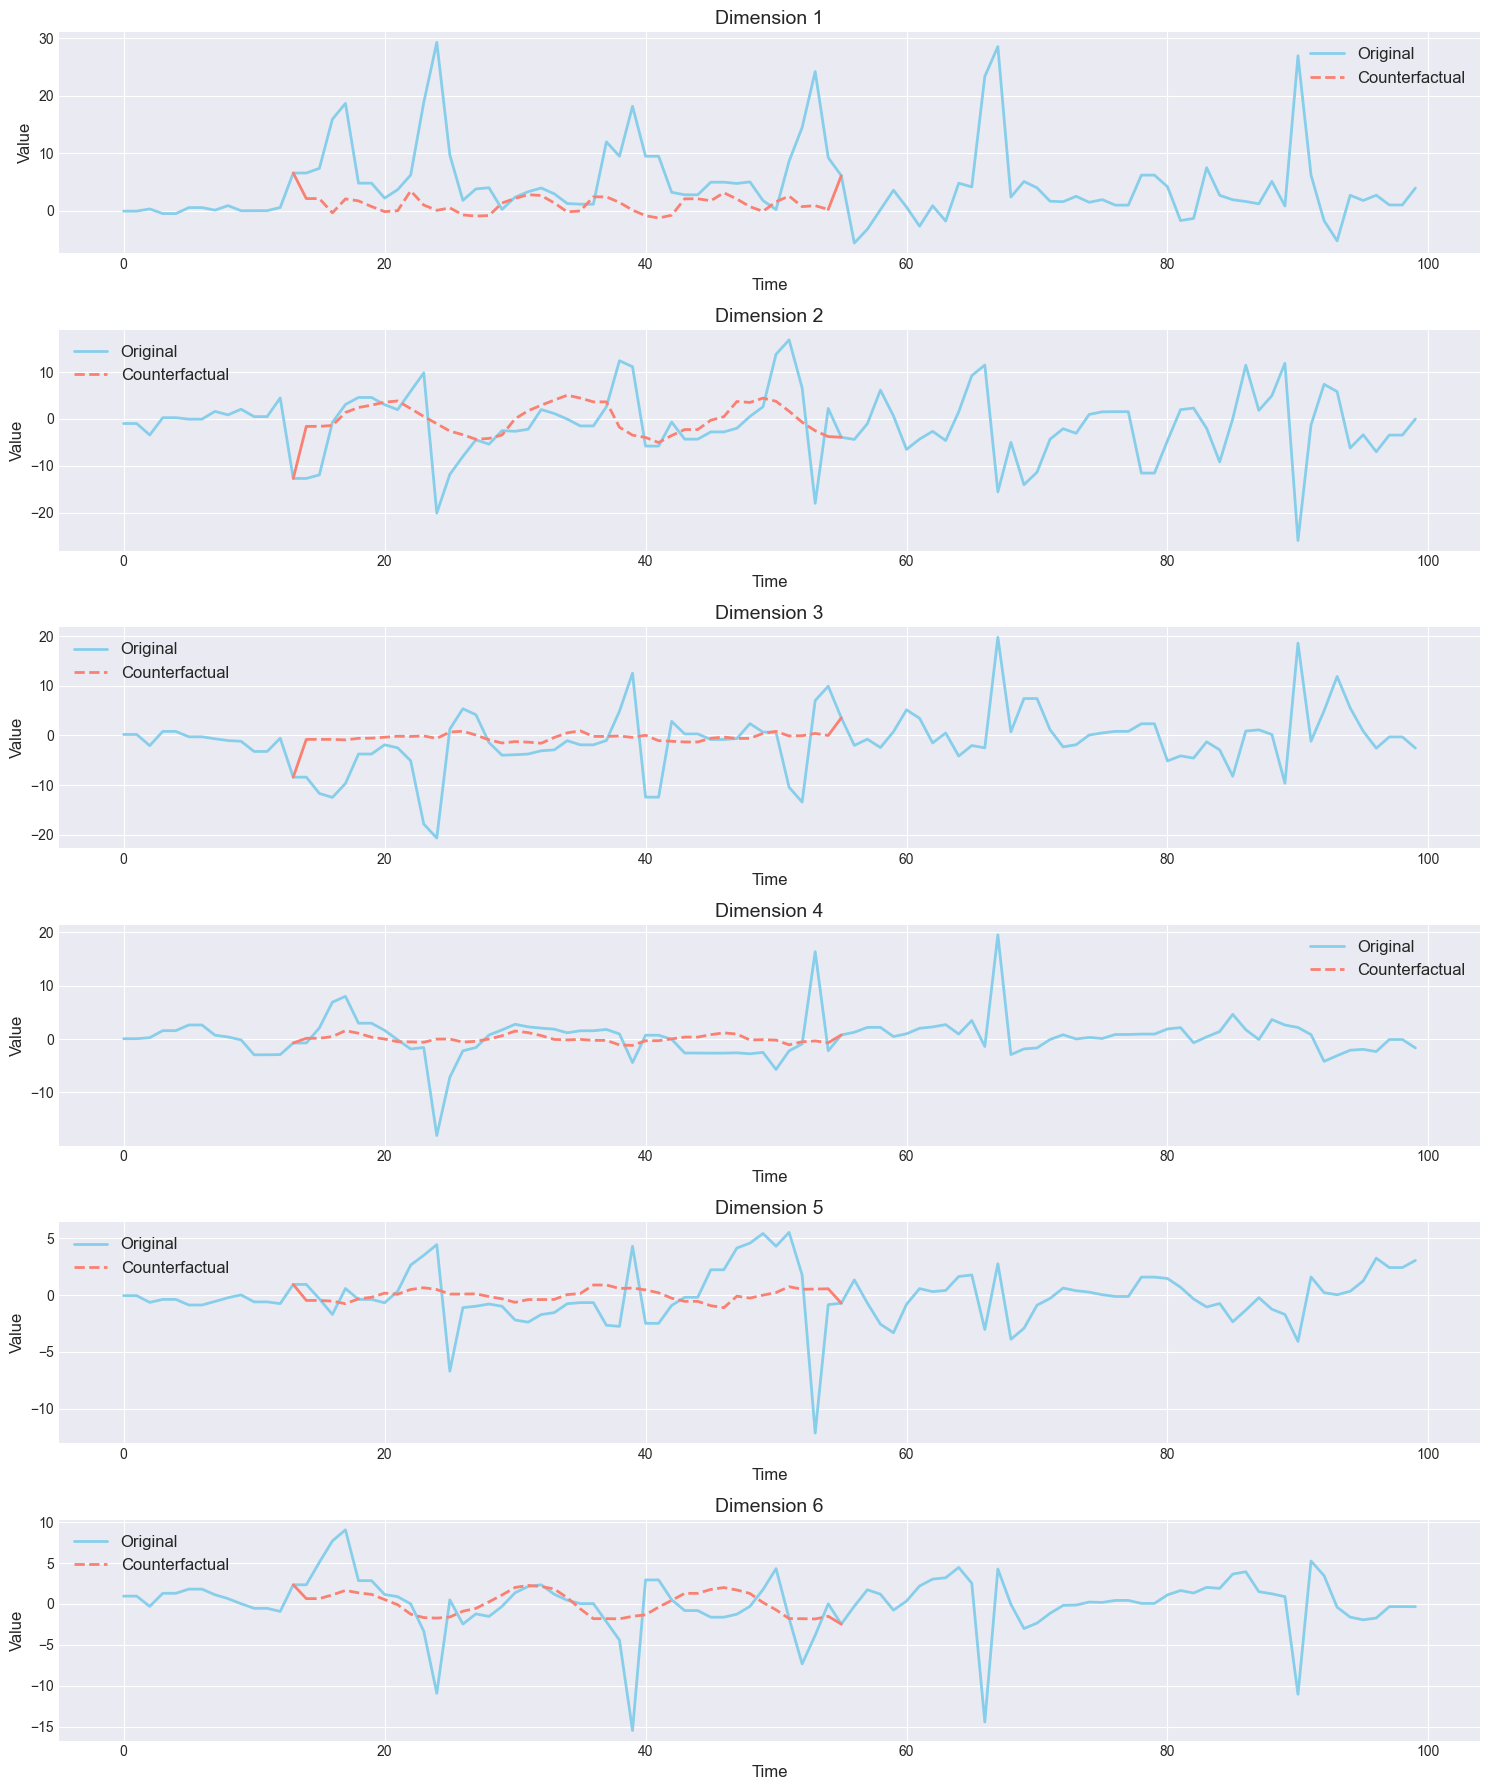

In [9]:
ce.visualize_counterfactuals(35)

/var/folders/1w/6qfp60h16m5cckc35cfvw47h0000gn/T/ipykernel_6402/4011654022.py:287: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # This applies a nice grid and background color


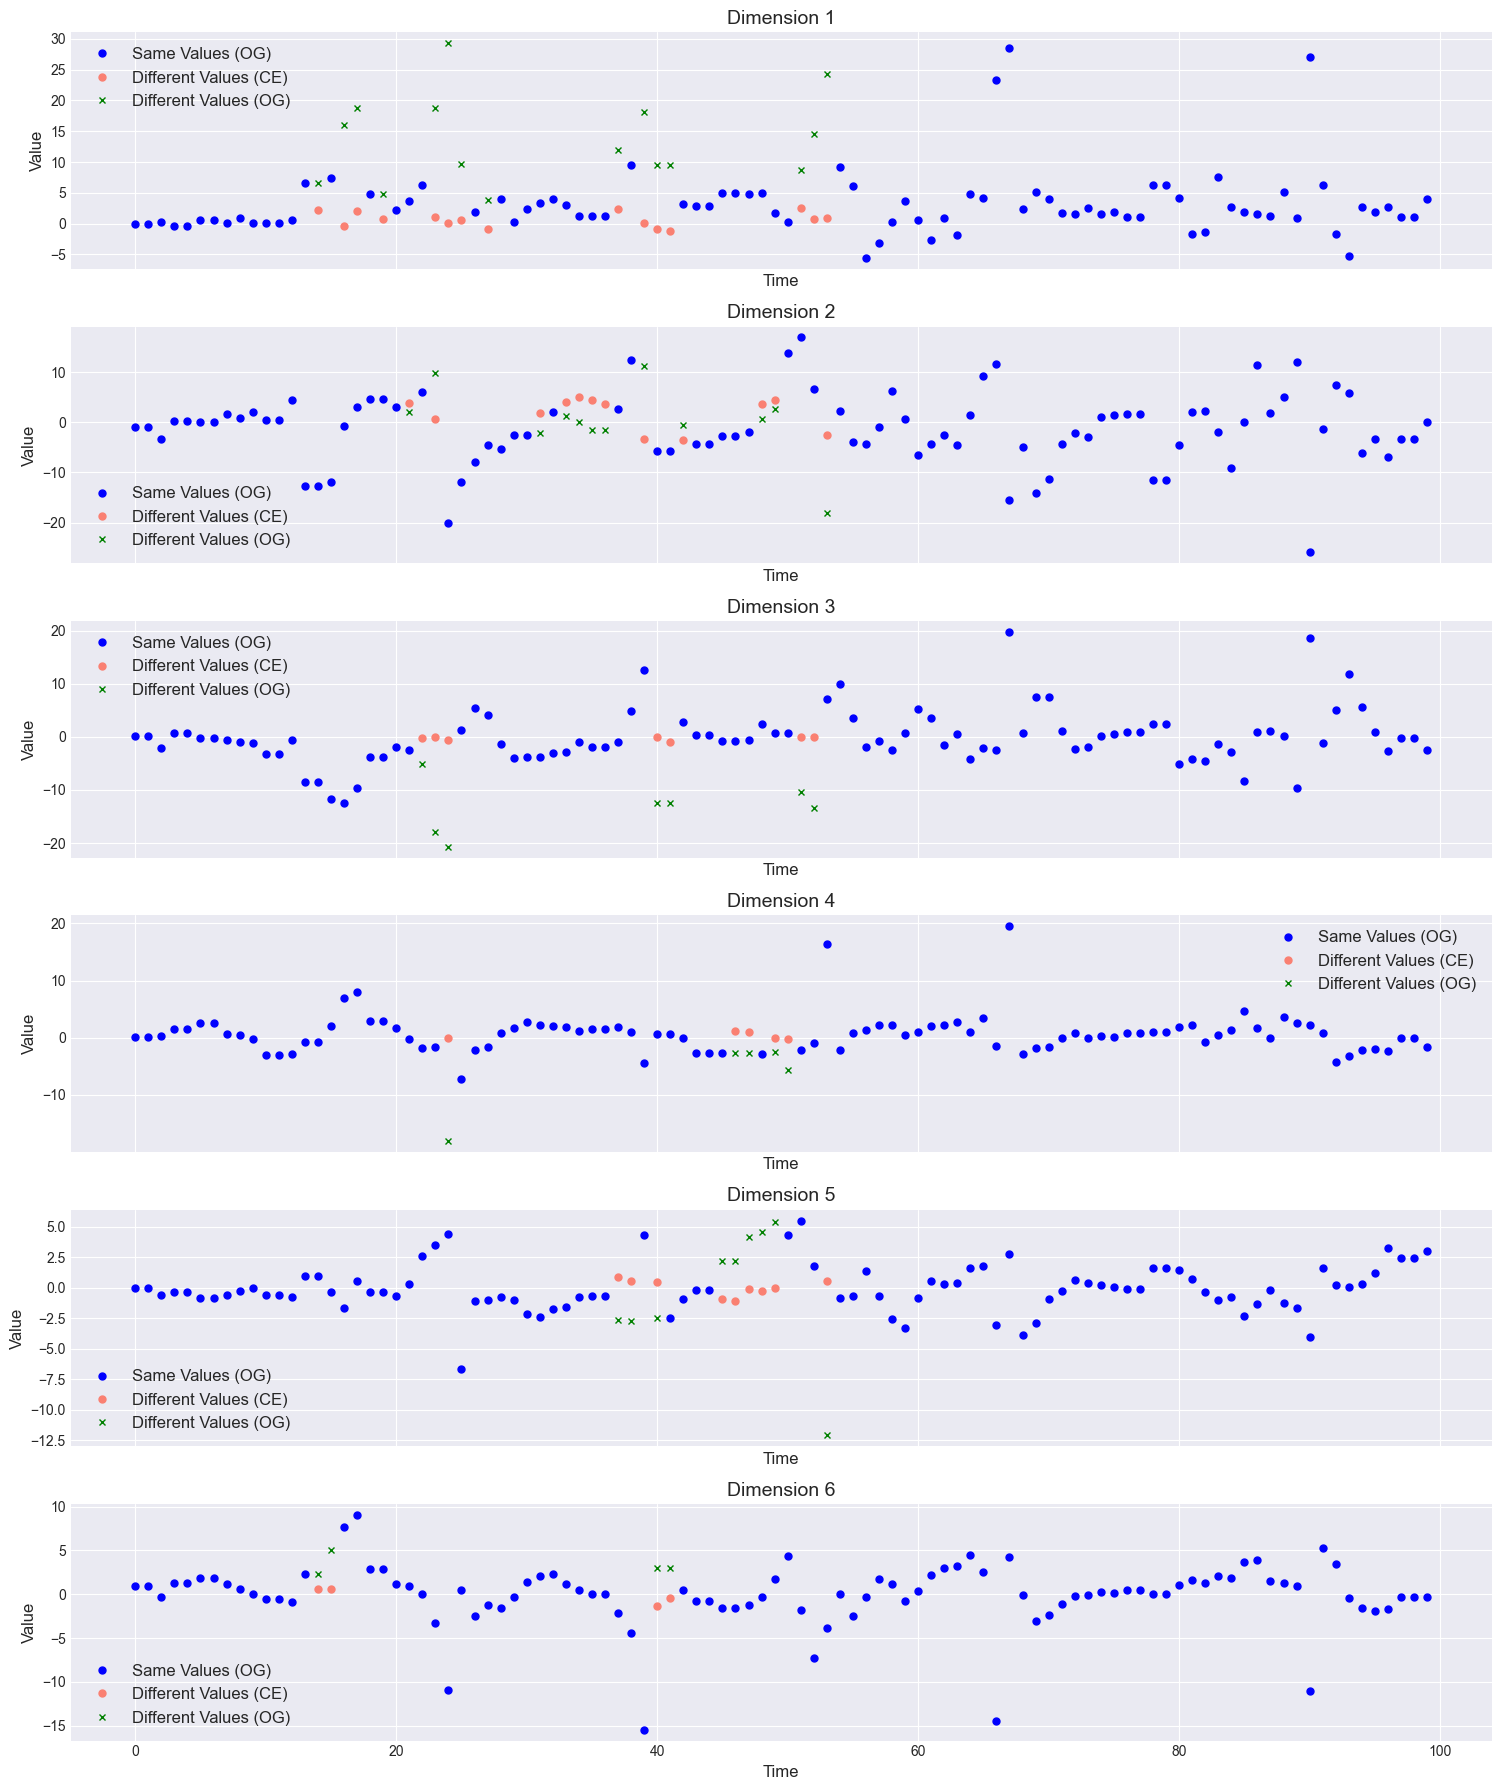

In [71]:
ce.visualize_marks(35,optimized=True,precision=False)

In [75]:
naive_dataframe = pd.DataFrame(columns=["Instance", "Window","Precision","Sparsity"])
for i, row in enumerate(ce.naive_counterfactuals):
    

(array([[-7.4065300e-01,  7.5650900e-01, -2.7580900e-01, -4.2347600e-01,
         1.3317000e-02,  1.3317000e-02],
       [-7.4065300e-01,  7.5650900e-01, -2.7580900e-01, -4.2347600e-01,
         1.3317000e-02,  1.3317000e-02],
       [ 1.0208449e+01, -9.2169700e+00, -1.2378901e+01, -1.4699153e+01,
         4.5783370e+00, -5.0550810e+00],
       [ 2.8670090e+00, -5.9771150e+00, -6.5409940e+00,  5.5611220e+00,
         2.1786390e+00, -1.6246570e+00],
       [-1.9430100e-01, -3.7119960e+00, -7.9512600e-01, -1.7285290e+00,
        -1.0546960e+00, -2.7699100e-01],
       [-1.9430100e-01, -3.7119960e+00, -7.9512600e-01, -1.7285290e+00,
        -1.0546960e+00, -2.7699100e-01],
       [-2.4961800e-01,  7.3168600e-01, -1.8674500e-01, -3.0628800e-01,
        -1.9975300e-01,  4.6609000e-01],
       [ 5.1607900e-01,  1.0701280e+00,  1.0928030e+00,  2.2905000e-01,
        -5.0870400e-01,  2.5302000e-01],
       [-2.5555200e-01,  5.8295600e-01,  1.3254650e+00, -1.6512900e-01,
        -9.5881000e-02,